In [10]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
import pandas as pd
from functools import partial
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel, SpatialWaves
from torch_training import train_epoch
#from torch_perturb.torch_pert_topk import PerturbedTopK
from torch_perturb.perturbations import perturbed
import time
from torch_training import train_epoch_largesynth, train_epoch_largesynth_loo
from torch_models import torch_bpr_uncurried, deterministic_bpr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def top_k_hot_indicator(x, k):

    topk = torch.topk(x, k=k, dim=-1, sorted=False)
    indices = topk.indices
    # convert to k-hot indicator with onehot function
    one_hot = torch.nn.functional.one_hot(indices, num_classes=x.shape[-1]).float()
    #khot = torch.mean(one_hot, dim=-2)
    return one_hot

In [12]:
top_k_hot_indicator(torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.4, 0.3, 0.2, 0.1]]), 3)

tensor([[[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]])

In [13]:
data_dir='/cluster/home/kheuto01/code/prob_diff_topk'

step_size=0.4
perturbed_noise=0.00001
K=25
threshold=1
rows=27
cols=60
data_shape=(rows, cols)
deaths = pd.read_csv(os.path.join(data_dir,'deaths_band.csv'))
pop = pd.read_csv(os.path.join(data_dir, 'pop_band.csv'))
num_score_samples = 100
num_pert_samples = 100
bpr_weight=30
nll_weight=0

# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(-rows/2, rows/2, rows)
lon = np.linspace(-cols/2, cols/2, cols)
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
deaths_TS = torch.tensor(deaths_TS, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


model  = SpatialWaves(num_waves=1,low=0, high=1000000)

optimizer = torch.optim.AdamW(model.parameters(), lr=step_size)

M_score_func =  num_score_samples
M_action = M_score_func

top_k_func = partial(top_k_hot_indicator, k=K)
perturbed_top_K_func = perturbed(top_k_func, sigma=perturbed_noise, num_samples=num_pert_samples)#PerturbedTopK(k=K, sigma=perturbed_noise, num_samples=num_pert_samples)

In [14]:
arrival_speed=torch.tensor([1.0], dtype=torch.float32)

lon_coeff = torch.tensor([0.0,], dtype=torch.float32)
lat_coeff = torch.tensor([-1.0], dtype=torch.float32)
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]], dtype=torch.float32) 
mag=torch.tensor([0.005], dtype=torch.float32)
width=torch.tensor([2.0], dtype=torch.float32)
softinv_mags = mag + torch.log(-torch.expm1(-mag))
softinv_widths = width + torch.log(-torch.expm1(-width))
#model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))

In [15]:
lat_S.dtype

torch.float32

# TODO: WHERE IS THE DOUBLE

In [16]:
arrival_speed.dtype

torch.float32

In [17]:
losses, bprs, nlls, times = [], [], [], []
for epoch in range(100):
    print(f'EPOCH: {epoch}')
    start = time.time()
    loss, bpr, nll, model = train_epoch_largesynth_loo(model, optimizer, K, threshold, T,
                                        M_score_func, M_action,time_T,pop_S,
                                        lat_S, lon_S, deaths_TS, 
                                        perturbed_top_K_func, bpr_weight, 
                                        nll_weight)
    end = time.time()
    elapsed = end - start
    losses.append(loss)
    bprs.append(bpr)
    nlls.append(nll)
    times.append(elapsed)

EPOCH: 0
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])


/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))


det bpr: 0.09417575597763062
Pert bpr: 0.09409095346927643
nll: 8.931434631347656
Loss: -2.8227286338806152


/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)


EPOCH: 1
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.1063835620880127
Pert bpr: 0.10661066323518753
nll: 11.188325881958008
Loss: -3.198319911956787
EPOCH: 2
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.11766377836465836
Pert bpr: 0.11754552274942398
nll: 10.730494499206543
Loss: -3.5263657569885254
EPOCH: 3
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.102779820561409
Pert bpr: 0.1026943176984787
nll: 12.689867973327637
Loss: -3.080829620361328
EPOCH: 4
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.09538255631923676
Pert bpr: 0.09538920223712921
nll: 17.261442184448242
Loss: -2.861675977706909
EPOCH: 5
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.09107986837625504
Pert bpr: 0.09105180203914642
nll: 19.95462417602539
Loss: -2.7315540313

In [128]:
train_y_TS = deaths_TS
update=False

In [53]:
from torch.autograd import profiler
with profiler.profile(use_cuda=True, profile_memory=True) as prof:
    with profiler.record_function("model_inference"):
        dist = model(time_T,pop_S, lat_S, lon_S)
    with profiler.record_function("jacobian calculation"):
        y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
        y_sample_action_TMS = y_sample_TMS

        ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
        ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
        ratio_rating_TS.requires_grad_(True)

        def get_log_probs_baked(param):
            distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
            log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

            return log_probs_TMS

        jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)
    with profiler.record_function("loss calc"):
        
        score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
        score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    

        # get gradient of negative bpr_t  with respect to ratio rating_TS
        print(f'train_y_TS size: {train_y_TS.shape}')
        print(f'ratio_rating_TS size: {ratio_rating_TS.shape}')
        positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
        if nll_weight>0:
            bpr_threshold_diff_T = positive_bpr_T - threshold
            violate_threshold_flag = bpr_threshold_diff_T < 0
            negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
        else:
            negative_bpr_loss = torch.mean(-positive_bpr_T)

        nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

        loss = bpr_weight*negative_bpr_loss + nll_weight*nll
    with profiler.record_function("backward"):
        loss.backward()
    with profiler.record_function("gradient update"):
        loss_grad_TS = ratio_rating_TS.grad

        gradient_TSP = score_func_estimator_TSP * torch.unsqueeze(loss_grad_TS, -1)
        gradient_P = torch.sum(gradient_TSP, dim=[0,1])

        gradient_tuple = model.single_tensor_to_params(gradient_P)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=1000))

/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/lib/python3.11/site-packages/torch/autograd/profiler.py:228: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
STAGE:2024-09-11 13:57:23 158313:158313 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])


/tmp/ipykernel_158313/1790547008.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
/tmp/ipykernel_158313/1790547008.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))
STAGE:2024-09-11 13:57:25 158313:158313 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-11 13:57:25 158313:158313 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              loss calc         0.05%     895.000us        46.55%     878.043ms     878.043ms     181.14 Mb      -3.97 Mb             1  
                                   jacobian calculation         0.41%       7.733ms        45.56%     859.399ms     859.399ms     338.26 Mb    -873.76 Mb             1  
                                          PerturbedFunc         5.95%     112.246ms        42.44%     800.551ms     800.551ms      59.72 Mb      -1.47

(array([9.6183e+04, 0.0000e+00, 3.1380e+03, 0.0000e+00, 1.2090e+03,
        0.0000e+00, 6.0500e+02, 0.0000e+00, 3.6800e+02, 0.0000e+00,
        2.1400e+02, 0.0000e+00, 1.5000e+02, 5.2000e+01, 5.3000e+01,
        1.3000e+01, 5.2000e+01, 3.0000e+00, 5.9000e+01, 2.0000e+00,
        4.4000e+01, 1.9000e+01, 1.5000e+01, 0.0000e+00, 3.9000e+01,
        0.0000e+00, 2.1000e+01, 1.0000e+01, 1.2000e+01, 1.4000e+01,
        0.0000e+00, 1.0000e+00, 1.4000e+01, 0.0000e+00, 1.2000e+01,
        4.0000e+00, 7.0000e+00, 1.1000e+01, 1.0000e+00, 0.0000e+00,
        6.0000e+00, 7.0000e+00, 2.0000e+00, 6.0000e+00, 0.0000e+00,
        6.0000e+00, 0.0000e+00, 4.0000e+00, 6.0000e+00, 3.0000e+00,
        3.0000e+00, 4.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        4.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00, 8.0000e+00,
        0.0000e+00, 7.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
        8.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00, 8.0000e+00,
        0.0000e+00, 7.0000e+00, 2.0000e+00, 4.00

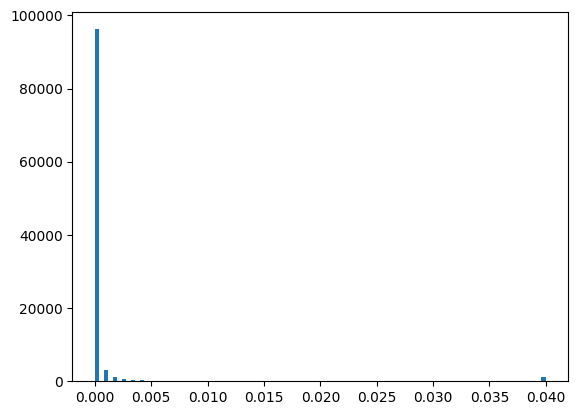

In [61]:
plt.hist(perturbed_top_K_func(ratio_rating_TS).detach().numpy().flatten(), bins=100)

In [44]:
p.export_chrome_trace("trace.json")

In [48]:
from torch.autograd import profiler
optimizer.zero_grad()
with torch.profiler.profile(profile_memory=True,
    activities=[
        torch.profiler.ProfilerActivity.CPU,
    ]
) as p:
        dist = model(time_T,pop_S, lat_S, lon_S)

        y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
        y_sample_action_TMS = y_sample_TMS

        ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
        ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
        ratio_rating_TS.requires_grad_(True)

        def get_log_probs_baked(param):
            distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
            log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

            return log_probs_TMS

        jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

        
        score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
        score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    

        # get gradient of negative bpr_t  with respect to ratio rating_TS
        print(f'train_y_TS size: {train_y_TS.shape}')
        print(f'ratio_rating_TS size: {ratio_rating_TS.shape}')
        positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
        if nll_weight>0:
            bpr_threshold_diff_T = positive_bpr_T - threshold
            violate_threshold_flag = bpr_threshold_diff_T < 0
            negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
        else:
            negative_bpr_loss = torch.mean(-positive_bpr_T)

        nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

        loss = bpr_weight*negative_bpr_loss + nll_weight*nll

        loss.backward()

        loss_grad_TS = ratio_rating_TS.grad

        gradient_TSP = score_func_estimator_TSP * torch.unsqueeze(loss_grad_TS, -1)
        gradient_P = torch.sum(gradient_TSP, dim=[0,1])

        gradient_tuple = model.single_tensor_to_params(gradient_P)


STAGE:2024-09-10 15:42:00 33778:33778 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


train_y_TS size: (64, 1620)
ratio_rating_TS size: torch.Size([64, 1620])


STAGE:2024-09-10 15:42:32 33778:33778 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-10 15:42:32 33778:33778 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [43]:
print(p.key_averages().table())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         aten::softplus         0.00%     112.000us         0.00%     319.000us      79.750us         128 b          32 b             4  
                                               [memory]         0.00%       0.000us         0.00%       0.000us       0.000us      -1.77 Gb      -1.77 Gb           250  
                                              aten::add         0.17%      49.527ms         0.85%     242.356ms       3.909ms     775.84 Mb     104.61

In [33]:
prof.events()

AttributeError: 'profile' object has no attribute 'events'

In [17]:
optimizer.zero_grad()
dist = model(time_T,pop_S, lat_S, lon_S)

y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
y_sample_action_TMS = y_sample_TMS

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
ratio_rating_TS.requires_grad_(True)

def get_log_probs_baked(param):
    distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
    log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

    return log_probs_TMS

jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)


BackendCompilerFailed: backend='inductor' raised:
CppCompileError: C++ compile error

Command:
g++ /tmp/torchinductor_kheuto01/jx/cjxsoagrmkidzkunygyxu3rchf4elvvcoicae6bthfbiteejr4vc.cpp -shared -fPIC -Wall -std=c++17 -Wno-unused-variable -Wno-unknown-pragmas -D_GLIBCXX_USE_CXX11_ABI=0 -I/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/lib/python3.11/site-packages/torch/include -I/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -I/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/lib/python3.11/site-packages/torch/include/TH -I/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/lib/python3.11/site-packages/torch/include/THC -I/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/include/python3.11 -L/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/lib/python3.11/site-packages/torch/lib -lgomp -lc10 -O3 -DNDEBUG -ffast-math -fno-finite-math-only -fno-unsafe-math-optimizations -ffp-contract=off -march=native -fopenmp -D C10_USING_CUSTOM_GENERATED_MACROS -o /tmp/torchinductor_kheuto01/jx/cjxsoagrmkidzkunygyxu3rchf4elvvcoicae6bthfbiteejr4vc.so

Output:
g++: error: unrecognized command line option ‘-std=c++17’


Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [15]:

score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    

# get gradient of negative bpr_t  with respect to ratio rating_TS
print(f'train_y_TS size: {train_y_TS.shape}')
print(f'ratio_rating_TS size: {ratio_rating_TS.shape}')
positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
if nll_weight>0:
    bpr_threshold_diff_T = positive_bpr_T - threshold
    violate_threshold_flag = bpr_threshold_diff_T < 0
    negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
else:
    negative_bpr_loss = torch.mean(-positive_bpr_T)

nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

loss = bpr_weight*negative_bpr_loss + nll_weight*nll
loss.backward()
loss_grad_TS = ratio_rating_TS.grad

gradient_TSP = score_func_estimator_TSP * torch.unsqueeze(loss_grad_TS, -1)
gradient_P = torch.sum(gradient_TSP, dim=[0,1])

gradient_tuple = model.single_tensor_to_params(gradient_P)

for param, gradient in zip(model.parameters(), gradient_tuple):
    if nll_weight>0:
        gradient = gradient + param.grad
    param.grad = gradient
if update:
    optimizer.step()

train_y_TS size: (64, 1620)
ratio_rating_TS size: torch.Size([64, 1620])


In [14]:
ratio_rating_TS.grad

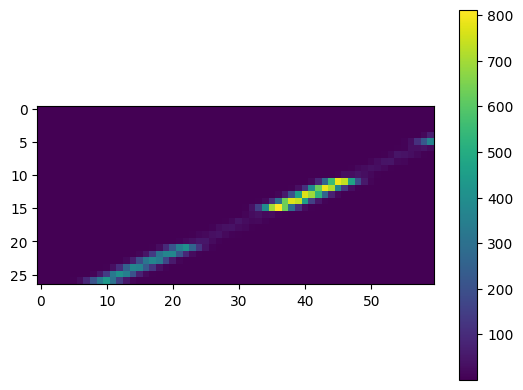

In [13]:
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((20, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[5,:].view(data_shape))
plt.colorbar()